In [27]:
### Setup

## For OpenGVLab/InternVL2_5-78B
# pip install lmdeploy timm flash-attn

# lmdeploy serve api_server OpenGVLab/InternVL2_5-78B --backend turbomind --server-port 23333 --dtype bfloat16 --tp 4


## For Qwen2-VL
# pip install git+https://github.com/huggingface/transformers@21fac7abba2a37fae86106f87fcf9974fd1e3830
# pip install accelerate
# pip install qwen-vl-utils
# pip install 'vllm==0.6.1' --extra-index-url https://download.pytorch.org/whl/cu121
# pip install flash-attn

# python -m vllm.entrypoints.openai.api_server --served-model-name Qwen2-VL-72B-Instruct --model Qwen/Qwen2-VL-72B-Instruct  --tensor-parallel-size 4


In [29]:
from openai import OpenAI
import re

client = OpenAI(
    base_url="http://localhost:23333/v1",
    # base_url="http://localhost:8000/v1",
    # base_url="http://0.tcp.ap.ngrok.io:17717/v1",
    api_key="token-abc123",
)

# model = "Qwen2-VL-7B-Instruct"
# model = "Qwen2-VL-72B-Instruct"
# model = "OpenGVLab/InternVL2_5-8B"
model = "OpenGVLab/InternVL2_5-78B"

In [7]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"

response = client.chat.completions.create(
  model=model,
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image?"},
        {"type": "image_url", "image_url": {"url": image_url}},
      ],
    }
  ],
  max_tokens=300,
)

print(response.choices[0].message.content);

The image depicts a wooden boardwalk path leading through a lush, green field of tall grass and vegetation. The sky above is clear and blue, with a few scattered clouds. The horizon is lined with a distant view of trees and possibly some farm structures, adding to the serene, natural landscape. The overall scene conveys a sense of tranquility and openness.


In [8]:
import base64

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# base64_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

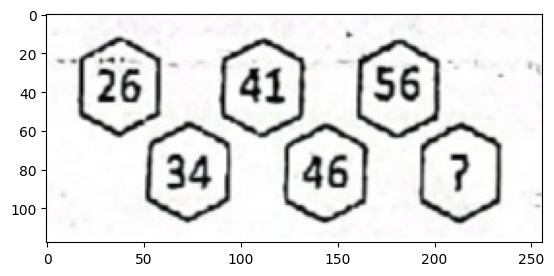

In [9]:
# Path to your image
image_path = "/media/shayekh/Data/_learn_/agents/vl-exams/data/iq8.png"
# image_path = "/media/shayekh/Data/_learn_/agents/vl-exams/data/chem.png"

# Getting the base64 string
base64_image = encode_image(image_path)

img = mpimg.imread(image_path)
plt.imshow(img)

image_url = f"data:image/jpeg;base64,{base64_image}"

In [10]:
# question = "What’s in this image?"
question = """Categorize the image: 

symbols, figures, graph, table, text-only, math formulae, chemical reactions, IQ question.

Answer in this format:

Explanation:
{Explanation}

Category:
{Category}
"""

response = client.chat.completions.create(
  model=model,
  messages=[{"role": "user", "content": [{"type": "text", "text": question},
        {"type": "image_url", "image_url": {"url": image_url}},], }],
  max_tokens=300,
  temperature=0.0,
)

print(response.choices[0].message.content)

Explanation:
The image contains a sequence of numbers arranged in hexagonal shapes. The numbers appear to follow a pattern or logic, which is typical of IQ questions designed to test numerical reasoning and pattern recognition.

Category:
IQ question


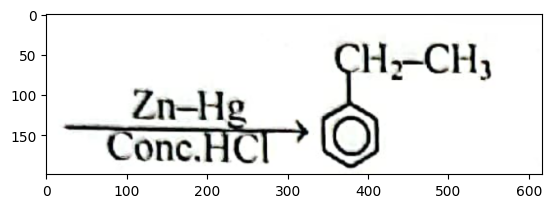

In [11]:
# Path to your image
image_path = "/media/shayekh/Data/_learn_/agents/vl-exams/data/chem.png"

# Getting the base64 string
base64_image = encode_image(image_path)

img = mpimg.imread(image_path)
plt.imshow(img)

image_url = f"data:image/jpeg;base64,{base64_image}"

In [11]:
# question = "What’s in this image?"
question = """Categorize the image: 

symbols, figures, graph, table, text-only, math formulae, chemical reactions, IQ question.

Only mention the category without additional explanations.
"""

response = client.chat.completions.create(
  model=model,
  messages=[{"role": "user", "content": [{"type": "text", "text": question},
        {"type": "image_url", "image_url": {"url": image_url}},], }],
  max_tokens=300,
  temperature=0.0,
)

print(response.choices[0].message.content)

chemical reactions


In [21]:
question = "What’s in this image?"
question = """Categorize the image: 

symbols, figures, graph, table, text-only, math formulae, chemical reaction.
"""

response = client.chat.completions.create(
  model="Qwen2-VL-7B-Instruct",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": question},
        {"type": "image_url", "image_url": {"url": image_url}},
      ],
    }
  ],
  max_tokens=300,
)

print(response.choices[0].message.content)

The image is a collection of symbols forming a pattern. The symbols in the image are the following numbers: 26, 41, 56, 34, 46, and 7.


In [17]:
PROMPT_IMAGE_TYPE = '''
You are an image classifier assistant. Your task is to take a look at an image and classify it by its main category using the following rubric:

'graph': Images showing data plotted on axes (line graphs, bar charts, scatter plots, pie charts, flowcharts, organizational charts, etc.).
'table': Structured data arranged in rows and columns.
'diagram': Technical or schematic drawings illustrating processes, structures, or concepts.
'scientific formula': Mathematical equations, chemical formulas, mathematical diagrams, or related.
'text': Images containing primarily textual information.
'figure': Illustrations, drawings, or visual representations of objects, patterns, or symbols.
'map': Geographical or spatial representations.
'photo': Photographic images of real-world scenes, objects, or people.

If categories overlap for the image, choose which's best representative of it.

Answer in this format:

Explanation:
{Explanation}

Category:
{Category}
'''

In [25]:
PROMPT_IMAGE_USEFUL = '''
You are an advanced image utility assessment assistant. Your role is to evaluate whether an image is essential or useful for answering a given question by following these precise guidelines:

- Essential Image Criteria:
  - The question DIRECTLY references or requires specific visual information from the image.
  - Answering the question would be impossible without examining the image.
  - The question asks about the content, details, or specifics visible in the image.

- Useful Image Criteria:
  - The image provides supplementary or supporting information.
  - The question can be answered comprehensively without the image.
  - The image offers additional context or insights but is not critical to the core answer.

Output Format:
  - If the image is essential: output "essential".
  - If the image is useful: output "useful".

Answer in this format:

Explanation:
{{Explanation}}

Utility:
{{essential or useful}}

Question: {}
'''

In [38]:
# question = "What’s in this image?"
question = PROMPT_IMAGE_TYPE

response = client.chat.completions.create(
  model=model,
  messages=[{"role": "user", "content": [{"type": "text", "text": question},
        {"type": "image_url", "image_url": {"url": image_url}},], }],
  max_tokens=300,
  temperature=0.0,
)

output = response.choices[0].message.content
print(output)

exp_pattern = r"Explanation:\s*(.*?)(?=Category:|$)"
    
# Pattern to match utility section
cat_pattern = r"Category:\s*(.*?)(?=\n|$)"
    
# Find matches
exp_match = re.search(exp_pattern, output, re.DOTALL)
cat_match = re.search(cat_pattern, output, re.DOTALL)
    
# Extract and clean the matches
explanation = exp_match.group(1).strip() if exp_match else None
category = cat_match.group(1).strip() if cat_match else None

print()
print("Explanation:", explanation)
print("Category:", category)

Explanation:
The image shows a chemical reaction scheme, which includes chemical structures and reaction conditions. This type of image is typically used to illustrate chemical processes or reactions in scientific literature.

Category:
diagram

Explanation: The image shows a chemical reaction scheme, which includes chemical structures and reaction conditions. This type of image is typically used to illustrate chemical processes or reactions in scientific literature.
Category: diagram


In [39]:
# question = "What’s in this image?"
question = PROMPT_IMAGE_USEFUL
query = "What is the input to the reaction?"

response = client.chat.completions.create(
  model=model,
  messages=[{"role": "user", "content": [{"type": "text", "text": question.format(query)},
        {"type": "image_url", "image_url": {"url": image_url}},], }],
  max_tokens=300,
  temperature=0.0,
)

output = response.choices[0].message.content
print(output)

exp_pattern = r"Explanation:\s*(.*?)(?=Utility:|$)"
    
# Pattern to match utility section
cat_pattern = r"Utility:\s*(.*?)(?=\n|$)"
    
# Find matches
exp_match = re.search(exp_pattern, output, re.DOTALL)
cat_match = re.search(cat_pattern, output, re.DOTALL)
    
# Extract and clean the matches
explanation = exp_match.group(1).strip() if exp_match else None
category = cat_match.group(1).strip() if cat_match else None

print()
print("Explanation:", explanation)
print("Utility:", category)

Explanation:
The image shows a chemical reaction involving a compound with a benzene ring and a chloroethyl group. The reaction uses Zn-Hg and concentrated HCl. The input to the reaction is the compound with the chloroethyl group attached to the benzene ring.

Utility:
essential

Explanation: The image shows a chemical reaction involving a compound with a benzene ring and a chloroethyl group. The reaction uses Zn-Hg and concentrated HCl. The input to the reaction is the compound with the chloroethyl group attached to the benzene ring.
Utility: essential
